In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from data_utils.dataset import ChangeDetectionDataset
from utils.main import FCSiamDiff, FCEF


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 8

train_dir = "./data/train"
val_dir = "./data/val"
test_dir = "./data/test"

data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

train_dataset = ChangeDetectionDataset(train_dir, data_transforms)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_dataset = ChangeDetectionDataset(val_dir, data_transforms)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True
)

test_dataset = ChangeDetectionDataset(test_dir, data_transforms)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

lr = 3e-4
num_epoches = 6

net = FCSiamDiff().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr)

loss_func = nn.BCEWithLogitsLoss()




In [2]:
l_his = []

for epoch in range(num_epoches):
    print("Epoch:", epoch + 1, "Training...")
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):

        x, labels = data["x"], data["mask"]

        x = x.to(device)
        labels = labels.to(device)

        x, labels = (
            Variable(x),
            Variable(labels.float()),
        )

        optimizer.zero_grad()
        f1 = net(x)
        loss = loss_func(f1, labels)
        loss.backward()
        optimizer.step()
        if i % 5 == 4:
            l_his.append(loss.item())
        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

Epoch: 1 Training...
[1,    50] loss: 0.280
[1,   100] loss: 0.258
[1,   150] loss: 0.251
[1,   200] loss: 0.245
[1,   250] loss: 0.243
[1,   300] loss: 0.237
[1,   350] loss: 0.234
[1,   400] loss: 0.227
[1,   450] loss: 0.227
[1,   500] loss: 0.218
[1,   550] loss: 0.216
[1,   600] loss: 0.210
[1,   650] loss: 0.203
[1,   700] loss: 0.201
[1,   750] loss: 0.195
[1,   800] loss: 0.191
[1,   850] loss: 0.185
Epoch: 2 Training...
[2,    50] loss: 0.177
[2,   100] loss: 0.172
[2,   150] loss: 0.167
[2,   200] loss: 0.164
[2,   250] loss: 0.160
[2,   300] loss: 0.155
[2,   350] loss: 0.154
[2,   400] loss: 0.151
[2,   450] loss: 0.146
[2,   500] loss: 0.147
[2,   550] loss: 0.142
[2,   600] loss: 0.138
[2,   650] loss: 0.135
[2,   700] loss: 0.132
[2,   750] loss: 0.133
[2,   800] loss: 0.129
[2,   850] loss: 0.126
Epoch: 3 Training...
[3,    50] loss: 0.117
[3,   100] loss: 0.120
[3,   150] loss: 0.116
[3,   200] loss: 0.113
[3,   250] loss: 0.115
[3,   300] loss: 0.112
[3,   350] loss: 

Finished Training


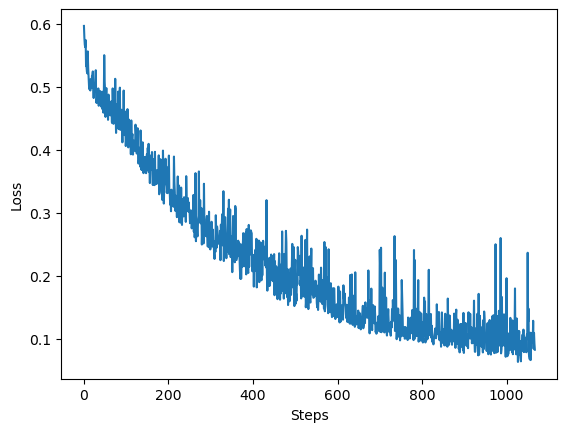

In [3]:

print("Finished Training")
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(l_his)
plt.xlabel("Steps")
plt.ylabel("Loss")
fig.savefig("plott2.png")

In [ ]:
for i, data in enumerate(val_dataloader, 0):

        x, labels = data["x"], data["mask"]

        x = x.to(device)
        labels = labels.to(device)


        with torch.no_grad():
            f1 = net(x)
            f1 = torch.round(torch.sigmoid(f1)).cpu().detach().numpy()

        for i in range(4):
            plt.figure()
            print(np.unique(f1[i][0]))
            plt.imshow(f1[i][0])
            plt.figure()
            plt.imshow(labels.cpu().numpy()[i][0])
            print(np.unique(f1[i][0]))
            plt.show(block=False)
